In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt #For plotting
np.random.seed(0) #For repeatability of the experiment
from sklearn import cross_validation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import warnings 
warnings.filterwarnings("ignore")

# Importing the data

In [3]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

pickle.dump(X,open('dataX.pickle','wb'))
pickle.dump(y,open('dataY.pickle','wb'))

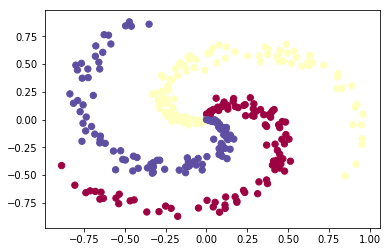

In [3]:
#Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [4]:
X.shape

(300, 2)

In [4]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)

# Question 1

In [8]:
# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 100 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))
W_cv=W
b_cv=b

W2 = 0.05 * np.random.randn(h,K)
b2 = np.zeros((1,K))
W2_cv=W2
b2_cv=b2


In [7]:
# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=5000

In [10]:
# gradient descent loop for relu
def grad_descent_relu(xtrain, xtest, ytrain, ytest,W,W2,b,b2,reg,step_size,num_examples,iterations):
    
    for i in range(iterations):

          # evaluate class scores, [N x K]
        hidden_layer = np.maximum(0, np.dot(xtrain, W) + b) # note, ReLU activation
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),ytrain])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
        loss = data_loss + reg_loss
#         if i % 5000 == 0:
#              print("iteration %d: loss %f" % (i, loss))

        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),ytrain] -= 1
        dscores /= num_examples

          # backpropate the gradient to the parameters
        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0
        # finally into W,b
        dW = np.dot(xtrain.T, dhidden)
        db = np.sum(dhidden, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW2 += reg * W2
        dW += reg * W

        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
        W2 += -step_size * dW2
        b2 += -step_size * db2


    hidden_layer = np.maximum(0, np.dot(xtest, W) + b)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    Accuracy=np.mean(predicted_class == ytest)
    #print('Accuracy: %.2f' % Accuracy)
    
           
    return W, W2,b,b2,Accuracy
    


In [9]:
W,W2,b,b2,Test_Accuracy = grad_descent_relu(xtrain, xtrain, ytrain, ytrain,W,W2,b,b2,reg,step_size,num_examples,iterations)
print('Training Accuracy: %.2f' % Test_Accuracy)

Training Accuracy: 0.93


In [41]:
W,W2,b,b2,Test_Accuracy = grad_descent_relu(xtrain, xtest, ytrain, ytest,W,W2,b,b2,reg,step_size,num_examples,iterations)
print('Test Accuracy: %.2f' % Test_Accuracy)

Test Accuracy: 0.92


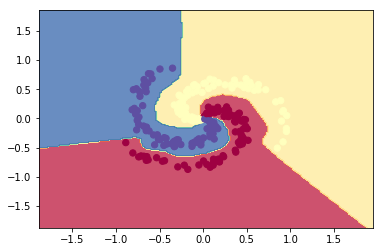

In [44]:
h = 0.02
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

#Cross-Validation Relu

In [43]:
D = xtrain.shape[1] #Number of features
h=100
K = max(ytrain)+1
reg = 1e-4 # regularization strength
#Initial value for the Gradient Descent Parameter
step_size = 1e-1
iterations=5000
kfold = KFold(5)
validation_accuracy=[]
factor=[0.01,0.05,0.5,1]
np.random.seed(0)
for item in factor:
    W = item * np.random.randn(D,h)
    b = np.zeros((1,h))
    W2= item * np.random.randn(h,K)
    b2=np.zeros((1,K))
    for k,(train,test) in enumerate(kfold.split(xtrain,ytrain)):
        w_cv=W
        B_cv=b
        B2_cv=b2
        w2_cv=W2
        num_examples=xtrain[train].shape[0]
        w,w2,b,b2,accuracy=grad_descent_relu(xtrain[train], xtrain[test], ytrain[train], ytrain[test],w_cv,w2_cv,B_cv,B2_cv,reg,step_size,num_examples,iterations)
        validation_accuracy.append(accuracy)
        #print('Validation Accuracy for fold %d: %.2f' % (k, accuracy))
        #print('done processing for k: %d' % k)
    
    #Avg_validation_accuracy.append(np.mean(validation_accuracy))
    print(item)
    print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(validation_accuracy), np.std(validation_accuracy) * 2))


0.01
Accuracy: 0.95 (+/- 0.10)
0.05
Accuracy: 0.95 (+/- 0.08)
0.5
Accuracy: 0.96 (+/- 0.08)
1
Accuracy: 0.96 (+/- 0.07)


#sensitivity of the model's performance to different learning rates and the number of gradient descent iterations.

In [62]:
#Defining expand grid function 
import itertools
import pandas as pd

def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [63]:
# Creating training grid
trainGrid = expand_grid({ 'num_iters':[100,500,1000,5000,10000],
                          'step_size': [1e-3,1e-2,1e-1,1e-0],
                         
                           #create a column to store accuracies in
                          'accuracy_mean': [0.0],
                         
                        })
trainGrid['num_iters']= trainGrid['num_iters'].apply(lambda x: int(x))

In [64]:
for idx,item in trainGrid.iterrows():
    print(item)
    kfold = KFold(10)
    validation_accuracy=[]
    iterations=int(item['num_iters'])
    stepsize=item['step_size'] 
    reg=1e-4
    for k,(train,test) in enumerate(kfold.split(X,y)):
        W = W_cv
        b = b_cv
        W2=W2_cv
        b2=b2_cv
        num_examples=X[train].shape[0]
        w,w2,b,b2,accuracy=grad_descent_relu(X[train], X[test], y[train], y[test],W,W2,b,b2,reg,stepsize,num_examples,iterations)
        validation_accuracy.append(accuracy)
        print('Validation Accuracy for fold %d: %.2f' % (k, accuracy))
        print('done processing for k: %d' % k)
    
    #Avg_validation_accuracy.append(np.mean(validation_accuracy))
    trainGrid.loc[idx,'accuracy_mean']=np.mean(validation_accuracy)
    
    print("Accuracy: %0.2f " % (trainGrid.loc[idx,'accuracy_mean']))
    print('**************')


num_iters        100.000
step_size          0.001
accuracy_mean      0.000
Name: 0, dtype: float64
Validation Accuracy for fold 0: 0.97
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2: 1.00
done processing for k: 2
Validation Accuracy for fold 3: 1.00
done processing for k: 3
Validation Accuracy for fold 4: 1.00
done processing for k: 4
Validation Accuracy for fold 5: 1.00
done processing for k: 5
Validation Accuracy for fold 6: 0.67
done processing for k: 6
Validation Accuracy for fold 7: 0.00
done processing for k: 7
Validation Accuracy for fold 8: 0.00
done processing for k: 8
Validation Accuracy for fold 9: 0.00
done processing for k: 9
Accuracy: 0.66 
**************
num_iters        100.00
step_size          0.01
accuracy_mean      0.00
Name: 1, dtype: float64
Validation Accuracy for fold 0: 0.90
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2

Validation Accuracy for fold 0: 0.57
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2: 1.00
done processing for k: 2
Validation Accuracy for fold 3: 0.67
done processing for k: 3
Validation Accuracy for fold 4: 1.00
done processing for k: 4
Validation Accuracy for fold 5: 1.00
done processing for k: 5
Validation Accuracy for fold 6: 0.67
done processing for k: 6
Validation Accuracy for fold 7: 1.00
done processing for k: 7
Validation Accuracy for fold 8: 1.00
done processing for k: 8
Validation Accuracy for fold 9: 0.37
done processing for k: 9
Accuracy: 0.83 
**************
num_iters        5000.000
step_size           0.001
accuracy_mean       0.000
Name: 12, dtype: float64
Validation Accuracy for fold 0: 0.87
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2: 1.00
done processing for k: 2
Validation Accuracy for fold 3: 0.90
done processing for k: 

In [65]:
print(trainGrid)

    num_iters  step_size  accuracy_mean
0         100      0.001       0.663333
1         100      0.010       0.783333
2         100      0.100       0.900000
3         100      1.000       0.886667
4         500      0.001       0.980000
5         500      0.010       0.940000
6         500      0.100       0.926667
7         500      1.000       0.873333
8        1000      0.001       0.976667
9        1000      0.010       0.953333
10       1000      0.100       0.930000
11       1000      1.000       0.826667
12       5000      0.001       0.963333
13       5000      0.010       0.943333
14       5000      0.100       0.860000
15       5000      1.000       0.743333
16      10000      0.001       0.953333
17      10000      0.010       0.936667
18      10000      0.100       0.830000
19      10000      1.000       0.690000


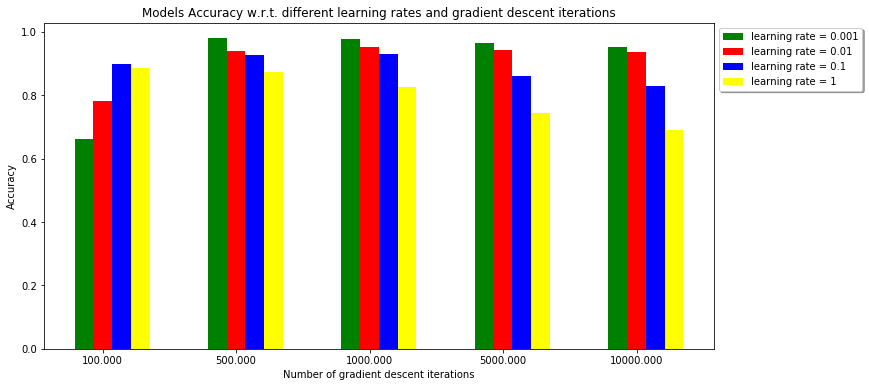

In [66]:
N = len(trainGrid['num_iters'].unique())
ind = np.arange(N)
width = 0.14

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
x_001 = tuple(list(trainGrid[trainGrid['step_size'] == 0.001].accuracy_mean))
#x_001 = (0.98333300000000001, 0.98666699999999996, 0.96999999999999997, 0.95666700000000005, 0.89333300000000004)
rects1 = ax.bar(ind,x_001,width,color = 'g')

x_01 = trainGrid[trainGrid['step_size'] == 0.01].accuracy_mean
rects2 = ax.bar(ind+width,x_01,width,color= 'r')

x_1 = trainGrid[trainGrid['step_size'] == 0.1].accuracy_mean
rects3 = ax.bar(ind+(2*width),x_1,width,color = 'b')

x1 = trainGrid[trainGrid['step_size'] == 1].accuracy_mean
rects4 = ax.bar(ind+(3*width),x1,width,color = 'yellow')

ax.set_xlabel('Number of gradient descent iterations')
ax.set_ylabel('Accuracy')
ax.set_title('Models Accuracy w.r.t. different learning rates and gradient descent iterations')
ax.set_xticks(ind+width)
#ax.annotate()
ax.set_xticklabels(tuple(["{0:0.3f}".format(x) for x in (trainGrid.num_iters.unique())]))
ax.legend((rects1[0], rects2[0], rects3[0],rects4[0],), ('learning rate = 0.001', 'learning rate = 0.01','learning rate = 0.1','learning rate = 1'),
          loc='upper left', bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True)
#ax.annotate()

plt.show()

In [5]:
import itertools
import pandas as pd

def expandgrid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [6]:
# Question 6 : What is the sensitivity of the model’s performance to different regularization parameter values. Find the best 
#              regularization parameter using an exhaustive search procedure. Describe your choice via suitable plots. What is 
#              the performance difference between using regularization and no regularization?

#Using the best fit found in the last part, we'll try to find the best regularization parameter:

trainGrid_reg = expandgrid({ 'reg': [0.5,1e-1,1e-2,1e-4,1e-5,0],
                              'num_iters':[5000],
                              'step_size': [1e-1],
                              'accuracy_mean': [0.0], #create a column to store accuracies in
                              
                        })


In [11]:
for idx,item in trainGrid_reg.iterrows():
    print(item)
    kfold = KFold(10)
    validation_accuracy=[]
    iterations=int(item['num_iters'])
    stepsize=item['step_size'] 
    
    reg=int(item['reg'])
    for k,(train,test) in enumerate(kfold.split(X,y)):
        W = W_cv
        b = b_cv
        W2=W2_cv
        b2=b2_cv
        num_examples=X[train].shape[0]
        w,w2,b,b2,accuracy=grad_descent_relu(X[train], X[test], y[train], y[test],W,W2,b,b2,reg,stepsize,num_examples,iterations)
        validation_accuracy.append(accuracy)
        print('Validation Accuracy for fold %d: %.2f' % (k, accuracy))
        print('done processing for k: %d' % k)
    
    #Avg_validation_accuracy.append(np.mean(validation_accuracy))
    trainGrid_reg.loc[idx,'accuracy_mean']=np.mean(validation_accuracy)
   
    print("Accuracy: %0.2f " % (trainGrid_reg.loc[idx,'accuracy_mean']))
    print('**************')

reg                 0.5
num_iters        5000.0
step_size           0.1
accuracy_mean       0.0
Name: 0, dtype: float64
Validation Accuracy for fold 0: 0.17
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2: 1.00
done processing for k: 2
Validation Accuracy for fold 3: 0.70
done processing for k: 3
Validation Accuracy for fold 4: 1.00
done processing for k: 4
Validation Accuracy for fold 5: 1.00
done processing for k: 5
Validation Accuracy for fold 6: 0.73
done processing for k: 6
Validation Accuracy for fold 7: 1.00
done processing for k: 7
Validation Accuracy for fold 8: 0.97
done processing for k: 8
Validation Accuracy for fold 9: 1.00
done processing for k: 9
Accuracy: 0.86 
**************
reg                 0.1
num_iters        5000.0
step_size           0.1
accuracy_mean       0.0
Name: 1, dtype: float64
Validation Accuracy for fold 0: 0.77
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done proce

In [12]:
trainGrid_reg

,reg,num_iters,step_size,accuracy_mean
0,0.50000,5000,0.1,0.856667
1,0.10000,5000,0.1,0.936667
2,0.01000,5000,0.1,0.946667
3,0.00010,5000,0.1,0.956667
4,0.00001,5000,0.1,0.956667
5,0.00000,5000,0.1,0.960000


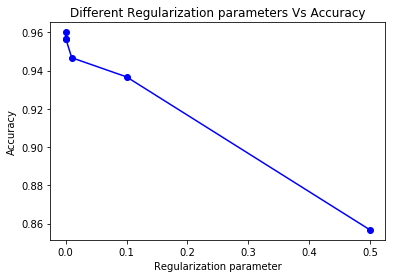

In [13]:
plt.plot(trainGrid_reg['reg'],trainGrid_reg['accuracy_mean'],'bo-')
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')
plt.title('Different Regularization parameters Vs Accuracy')
plt.show()

In [75]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50)

In [76]:
# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 100 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))

W2 = 0.05 * np.random.randn(h,K)
b2 = np.zeros((1,K))


In [77]:
# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=5000

In [78]:
W,W2,b,b2,Test_Accuracy = grad_descent_relu(xtrain, xtest, ytrain, ytest,W,W2,b,b2,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)


Test Accuracy: 0.90


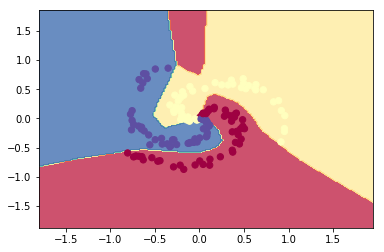

In [79]:
h = 0.02
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

In [80]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.40)
# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 100 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))

W2 = 0.05 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=5000

W,W2,b,b2,Test_Accuracy = grad_descent_relu(xtrain, xtest, ytrain, ytest,W,W2,b,b2,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)


Test Accuracy: 0.91


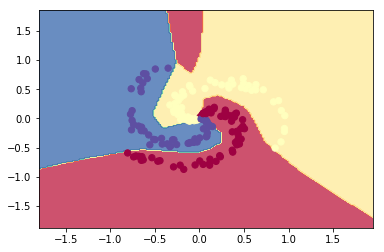

In [81]:
h = 0.02
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

# Question 2

In [11]:
# gradient descent loop for relu
def grad_descent_Leaky_relu(xtrain, xtest, ytrain, ytest,W,W2,b,b2,reg,step_size,num_examples,iterations):
    
    for i in range(iterations):

          # evaluate class scores, [N x K]
        x=np.dot(xtrain, W) + b   
        alpha=0.01
        hidden_layer = np.maximum(alpha*x,x) # note, leaky ReLU activation
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),ytrain])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
        loss = data_loss + reg_loss
#         if i % 5000 == 0:
#              print("iteration %d: loss %f" % (i, loss))

        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),ytrain] -= 1
        dscores /= num_examples

          # backpropate the gradient to the parameters
        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
        # backprop the leaky ReLU non-linearity
        dhidden[hidden_layer <= 0] *= alpha
        # finally into W,b
        dW = np.dot(xtrain.T, dhidden)
        db = np.sum(dhidden, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW2 += reg * W2
        dW += reg * W

        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
        W2 += -step_size * dW2
        b2 += -step_size * db2


    x_test=np.dot(xtest, W) + b
    hidden_layer = np.maximum(alpha * x_test, x_test)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    Accuracy=np.mean(predicted_class == ytest)
    #print('Accuracy: %.2f' % Accuracy)
    
           
    return W, W2,b,b2,Accuracy

In [12]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)

In [13]:
# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 150 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))

W2 = 0.05 * np.random.randn(h,K)
b2 = np.zeros((1,K))


In [85]:
W2_cv=W2
b2_cv=b2
b_cv=b
W_cv=W

In [14]:
# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=5000

In [15]:
W,W2,b,b2,Training_Accuracy = grad_descent_Leaky_relu(xtrain, xtrain, ytrain, ytrain,W,W2,b,b2,reg,step_size,num_examples,iterations) 
print('Training Accuracy: %.2f' % Training_Accuracy)

Training Accuracy: 0.95


In [87]:
W,W2,b,b2,Test_Accuracy = grad_descent_Leaky_relu(xtrain, xtest, ytrain, ytest,W,W2,b,b2,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)

Test Accuracy: 0.92


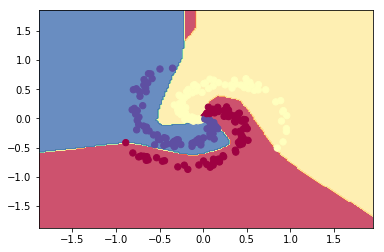

In [88]:
h = 0.020
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0.01*(np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

In [89]:
h=150
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1
reg = 1e-4 # regularization strength
#Initial value for the Gradient Descent Parameter
step_size = 1e-1
iterations=5000
kfold = KFold(10)
validation_accuracy=[]

factor=[0.01,0.05,0.5,1]
np.random.seed(0)
for item in factor:
    W = item*np.random.randn(D,h)
    b = np.zeros((1,h))
    W2= item * np.random.randn(h,K)
    b2=np.zeros((1,K))
    for k,(train,test) in enumerate(kfold.split(xtrain,ytrain)):
        w_cv=W
        B_cv=b
        B2_cv=b2
        w2_cv=W2
        num_examples=xtrain[train].shape[0]
        w,w2,b,b2,accuracy=grad_descent_Leaky_relu(xtrain[train], xtrain[test], ytrain[train], ytrain[test],w_cv,w2_cv,B_cv,B2_cv,reg,step_size,num_examples,iterations)
        validation_accuracy.append(accuracy)
        #print('Validation Accuracy for fold %d: %.2f' % (k, accuracy))
        #print('done processing for k: %d' % k)
    
    #Avg_validation_accuracy.append(np.mean(validation_accuracy))
    print("Weight multipler: %0.2f"%(item))
    print("Accuracy: %0.2f" % (np.mean(validation_accuracy)))

Weight multipler: 0.01
Accuracy: 0.96
Weight multipler: 0.05
Accuracy: 0.96
Weight multipler: 0.50
Accuracy: 0.97
Weight multipler: 1.00
Accuracy: 0.97


In [92]:
#Defining expand grid function 
import itertools
import pandas as pd

def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [93]:
# Creating training grid
trainGrid = expand_grid({ 'num_iters':[100,200,1000,5000,10000],
                          'step_size': [1e-3,1e-2,1e-1,1e-0],
                         
                           #create a column to store accuracies in
                          'accuracy_mean': [0.0],
                         
                           
                        })
trainGrid['num_iters']= trainGrid['num_iters'].apply(lambda x: int(x))

In [94]:
for idx,item in trainGrid.iterrows():
    print(item)
    kfold = KFold(10)
    validation_accuracy=[]
    iterations=int(item['num_iters'])
    stepsize=item['step_size'] 
    reg=1e-4
    for k,(train,test) in enumerate(kfold.split(X,y)):
        W = W_cv
        b = b_cv
        W2=W2_cv
        b2=b2_cv
        num_examples=X[train].shape[0]
        w,w2,b,b2,accuracy=grad_descent_Leaky_relu(X[train], X[test], y[train], y[test],W,W2,b,b2,reg,stepsize,num_examples,iterations)
        validation_accuracy.append(accuracy)
        print('Validation Accuracy for fold %d: %.2f' % (k, accuracy))
        print('done processing for k: %d' % k)
    
    #Avg_validation_accuracy.append(np.mean(validation_accuracy))
    trainGrid.loc[idx,'accuracy_mean']=np.mean(validation_accuracy)
    trainGrid.loc[idx,'accuracy_std']=np.std(validation_accuracy) * 2
    print("Accuracy: %0.2f " % (trainGrid.loc[idx,'accuracy_mean']))
    print('**************')


num_iters        100.000
step_size          0.001
accuracy_mean      0.000
Name: 0, dtype: float64
Validation Accuracy for fold 0: 0.70
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2: 1.00
done processing for k: 2
Validation Accuracy for fold 3: 0.73
done processing for k: 3
Validation Accuracy for fold 4: 1.00
done processing for k: 4
Validation Accuracy for fold 5: 1.00
done processing for k: 5
Validation Accuracy for fold 6: 0.93
done processing for k: 6
Validation Accuracy for fold 7: 0.97
done processing for k: 7
Validation Accuracy for fold 8: 1.00
done processing for k: 8
Validation Accuracy for fold 9: 1.00
done processing for k: 9
Accuracy: 0.93 
**************
num_iters        100.00
step_size          0.01
accuracy_mean      0.00
Name: 1, dtype: float64
Validation Accuracy for fold 0: 0.60
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2

Validation Accuracy for fold 0: 0.40
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2: 1.00
done processing for k: 2
Validation Accuracy for fold 3: 0.70
done processing for k: 3
Validation Accuracy for fold 4: 1.00
done processing for k: 4
Validation Accuracy for fold 5: 1.00
done processing for k: 5
Validation Accuracy for fold 6: 0.63
done processing for k: 6
Validation Accuracy for fold 7: 1.00
done processing for k: 7
Validation Accuracy for fold 8: 1.00
done processing for k: 8
Validation Accuracy for fold 9: 0.50
done processing for k: 9
Accuracy: 0.82 
**************
num_iters        5000.000
step_size           0.001
accuracy_mean       0.000
Name: 12, dtype: float64
Validation Accuracy for fold 0: 0.87
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2: 1.00
done processing for k: 2
Validation Accuracy for fold 3: 0.90
done processing for k: 

In [95]:
print(trainGrid)

    num_iters  step_size  accuracy_mean  accuracy_std
0         100      0.001       0.933333      0.221108
1         100      0.010       0.870000      0.335261
2         100      0.100       0.843333      0.466714
3         100      1.000       0.846667      0.475348
4         200      0.001       0.983333      0.068313
5         200      0.010       0.943333      0.176509
6         200      0.100       0.916667      0.255169
7         200      1.000       0.896667      0.329916
8        1000      0.001       0.976667      0.073333
9        1000      0.010       0.943333      0.173973
10       1000      0.100       0.920000      0.244404
11       1000      1.000       0.823333      0.457092
12       5000      0.001       0.960000      0.125786
13       5000      0.010       0.943333      0.173973
14       5000      0.100       0.900000      0.261619
15       5000      1.000       0.676667      0.659326
16      10000      0.001       0.950000      0.163978
17      10000      0.010    

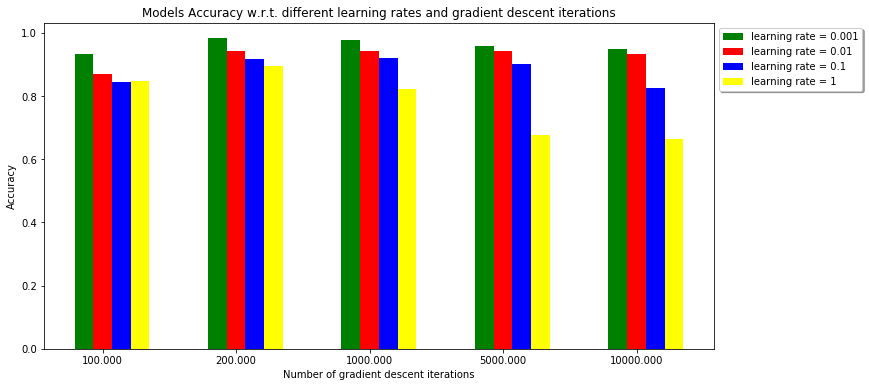

In [96]:
N = len(trainGrid['num_iters'].unique())
ind = np.arange(N)
width = 0.14

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
x_001 = tuple(list(trainGrid[trainGrid['step_size'] == 0.001].accuracy_mean))
rects1 = ax.bar(ind,x_001,width,color = 'g')

x_01 = trainGrid[trainGrid['step_size'] == 0.01].accuracy_mean
rects2 = ax.bar(ind+width,x_01,width,color= 'r')

x_1 = trainGrid[trainGrid['step_size'] == 0.1].accuracy_mean
rects3 = ax.bar(ind+(2*width),x_1,width,color = 'b')

x1 = trainGrid[trainGrid['step_size'] == 1].accuracy_mean
rects4 = ax.bar(ind+(3*width),x1,width,color = 'yellow')

ax.set_xlabel('Number of gradient descent iterations')
ax.set_ylabel('Accuracy')
ax.set_title('Models Accuracy w.r.t. different learning rates and gradient descent iterations')
ax.set_xticks(ind+width)
#ax.annotate()
ax.set_xticklabels(tuple(["{0:0.3f}".format(x) for x in (trainGrid.num_iters.unique())]))
ax.legend((rects1[0], rects2[0], rects3[0],rects4[0],), ('learning rate = 0.001', 'learning rate = 0.01','learning rate = 0.1','learning rate = 1'),
          loc='upper left', bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True)
#ax.annotate()

plt.show()

In [97]:
import itertools
import pandas as pd

def expandgrid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [98]:
# Question 6 : What is the sensitivity of the model’s performance to different regularization parameter values. Find the best 
#              regularization parameter using an exhaustive search procedure. Describe your choice via suitable plots. What is 
#              the performance difference between using regularization and no regularization?

#Using the best fit found in the last part, we'll try to find the best regularization parameter:

trainGrid_reg = expandgrid({ 'reg': [1e-1,1e-2,1e-3,1e-4,0],
                              'num_iters':[5000],
                              'step_size': [1e-1],
                              'accuracy_mean': [0.0], #create a column to store accuracies in
                              
                        })
trainGrid_reg

,reg,num_iters,step_size,accuracy_mean
0,0.1000,5000,0.1,0.0
1,0.0100,5000,0.1,0.0
2,0.0010,5000,0.1,0.0
3,0.0001,5000,0.1,0.0
4,0.0000,5000,0.1,0.0


In [99]:
for idx,item in trainGrid_reg.iterrows():
    print(item)
    kfold = KFold(10)
    validation_accuracy=[]
    iterations=int(item['num_iters'])
    stepsize=item['step_size'] 
    
    reg=int(item['reg'])
    for k,(train,test) in enumerate(kfold.split(X,y)):
        W = W_cv
        b = b_cv
        W2=W2_cv
        b2=b2_cv
        num_examples=X[train].shape[0]
        w,w2,b,b2,accuracy=grad_descent_Leaky_relu(X[train], X[test], y[train], y[test],W,W2,b,b2,reg,stepsize,num_examples,iterations)
        validation_accuracy.append(accuracy)
        print('Validation Accuracy for fold %d: %.2f' % (k, accuracy))
        print('done processing for k: %d' % k)
    
    #Avg_validation_accuracy.append(np.mean(validation_accuracy))
    trainGrid_reg.loc[idx,'accuracy_mean']=np.mean(validation_accuracy)
    print("Accuracy: %0.2f" % (trainGrid_reg.loc[idx,'accuracy_mean']))
    print('**************')

reg                 0.1
num_iters        5000.0
step_size           0.1
accuracy_mean       0.0
Name: 0, dtype: float64
Validation Accuracy for fold 0: 0.67
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2: 1.00
done processing for k: 2
Validation Accuracy for fold 3: 0.83
done processing for k: 3
Validation Accuracy for fold 4: 1.00
done processing for k: 4
Validation Accuracy for fold 5: 1.00
done processing for k: 5
Validation Accuracy for fold 6: 0.80
done processing for k: 6
Validation Accuracy for fold 7: 1.00
done processing for k: 7
Validation Accuracy for fold 8: 1.00
done processing for k: 8
Validation Accuracy for fold 9: 1.00
done processing for k: 9
Accuracy: 0.93
**************
reg                 0.01
num_iters        5000.00
step_size           0.10
accuracy_mean       0.00
Name: 1, dtype: float64
Validation Accuracy for fold 0: 0.80
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done pr

In [100]:
trainGrid_reg

,reg,num_iters,step_size,accuracy_mean
0,0.1000,5000,0.1,0.930000
1,0.0100,5000,0.1,0.943333
2,0.0010,5000,0.1,0.953333
3,0.0001,5000,0.1,0.956667
4,0.0000,5000,0.1,0.960000


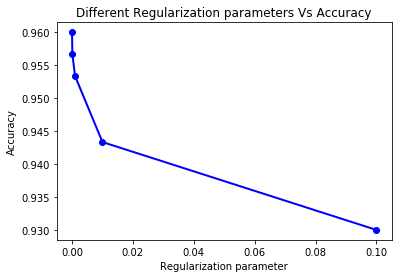

In [101]:
plt.plot(trainGrid_reg['reg'],trainGrid_reg['accuracy_mean'],'bo-',  linewidth=2)
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')
plt.title('Different Regularization parameters Vs Accuracy')
plt.show()

In [114]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50)

In [115]:
# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 150 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))

W2 = 0.05 * np.random.randn(h,K)
b2 = np.zeros((1,K))


In [116]:
# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=5000

In [117]:
W,W2,b,b2,Test_Accuracy = grad_descent_Leaky_relu(xtrain, xtest, ytrain, ytest,W,W2,b,b2,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)

Test Accuracy: 0.92


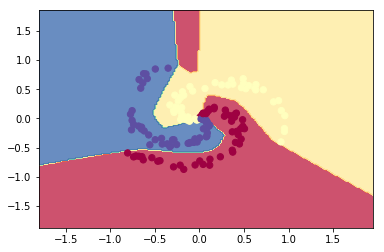

In [118]:
h = 0.020
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0.01*(np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

In [112]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.40)
# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 150 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))
print(W.shape)

W2 = 0.05 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=5000

W,W2,b,b2,Test_Accuracy = grad_descent_Leaky_relu(xtrain, xtest, ytrain, ytest,W,W2,b,b2,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)

(2, 150)
Test Accuracy: 0.91


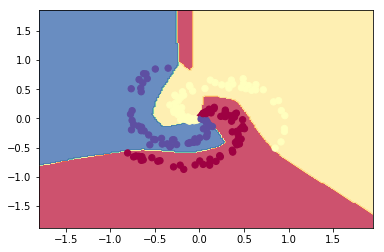

In [113]:
h = 0.020
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0.01*(np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

# Question 3

In [16]:
# gradient descent loop for relu
def grad_descent_maxout(xtrain, xtest, ytrain, ytest,W,W2,W3,b,b2,b3,reg,step_size,num_examples,iterations):
    
    for i in range(iterations):

          # evaluate class scores, [N x K]
        x1=np.dot(xtrain, W) + b   
        x2=np.dot(xtrain, W2) + b2  
        hidden_layer = np.maximum(x2,x1) # note, leaky ReLU activation
        #print(x2.shape)
        scores = np.dot(hidden_layer, W3) + b3
        #print(scores.shape)
        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),ytrain])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)+0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
#         if i % 5000 == 0:
#              print("iteration %d: loss %f" % (i, loss))

        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),ytrain] -= 1
        dscores /= num_examples

          # backpropate the gradient to the parameters
        # first backprop into parameters W3 and b3
        dW3 = np.dot(hidden_layer.T, dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True)
        
        # next backprop into hidden layer for W and b
        dhidden_1 = np.dot(dscores, W3.T)
        # backprop the leaky ReLU non-linearity
        dhidden_1[x1 < x2] = 0
        # finally into W,b
        dW = np.dot(xtrain.T, dhidden_1)
        db = np.sum(dhidden_1, axis=0, keepdims=True)
        
        # next backprop into hidden layer for W2 and b2
        dhidden_2 = np.dot(dscores, W3.T)
        # backprop the leaky ReLU non-linearity
        dhidden_2[x2 < x1] = 0
        # finally into W,b
        dW2 = np.dot(xtrain.T, dhidden_2)
        db2 = np.sum(dhidden_2, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW3 += reg * W3
        dW2 += reg * W2
        dW += reg * W

        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W3 += -step_size * dW3
        b3 += -step_size * db3


    x_test_1=np.dot(xtest, W) + b
    x_test_2=np.dot(xtest, W2) + b2
    hidden_layer = np.maximum(x_test_2, x_test_1)
    scores = np.dot(hidden_layer, W3) + b3
    predicted_class = np.argmax(scores, axis=1)
    Accuracy=np.mean(predicted_class == ytest)
    #print('Accuracy: %.2f' % Accuracy)
    
           
    return W, W2,W3,b,b2,b3,Accuracy

In [17]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)

In [18]:

# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 100 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))

W3 = 0.05 * np.random.randn(h,K)
b3 = np.zeros((1,K))

W2 = 0.05 * np.random.randn(D,h)
b2 = np.zeros((1,h))

W_cv=W
b_cv=b
W2_cv=W2
b2_cv=b2
W3_cv=W3
b3_cv=b3


In [19]:
# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=3000

In [20]:
W,W2,W3,b,b2,b3,Train_Accuracy = grad_descent_maxout(xtrain, xtrain, ytrain, ytrain,W,W2,W3,b,b2,b3,reg,step_size,num_examples,iterations) 
print('Training Accuracy: %.2f' % Train_Accuracy)

Training Accuracy: 0.94


In [155]:
W,W2,W3,b,b2,b3,Test_Accuracy = grad_descent_maxout(xtrain, xtest, ytrain, ytest,W,W2,W3,b,b2,b3,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)

Test Accuracy: 0.92


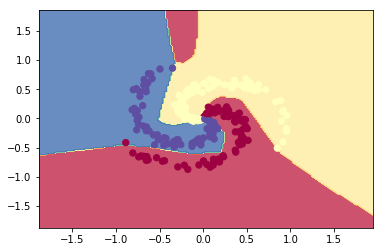

In [157]:
h = 0.020
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(np.dot(np.c_[xx.ravel(), yy.ravel()], W2) + b2, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W3) + b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

In [152]:
h=100
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1
reg = 1e-4 # regularization strength
#Initial value for the Gradient Descent Parameter
step_size = 1e-1
iterations=3000
kfold = KFold(10)
validation_accuracy=[]

factor=[0.01,0.05,0.5,1]
np.random.seed(0)
for item in factor:
    W = item * np.random.randn(D,h)
    b = np.zeros((1,h))

    W3 = item * np.random.randn(h,K)
    b3 = np.zeros((1,K))

    W2 = item * np.random.randn(D,h)
    b2 = np.zeros((1,h))
    for k,(train,test) in enumerate(kfold.split(xtrain,ytrain)):
        w_cv=W
        B_cv=b
        B2_cv=b2
        w2_cv=W2
        B3_cv=b3
        w3_cv=W3
        num_examples=xtrain[train].shape[0]
        W,W2,W3,b,b2,b3,accuracy = grad_descent_maxout(xtrain[train], xtrain[test], ytrain[train], ytrain[test],w_cv,w2_cv,w3_cv,B_cv,B2_cv,B3_cv,reg,step_size,num_examples,iterations) 
        validation_accuracy.append(accuracy)
        #print('Validation Accuracy for fold %d: %.2f' % (k, accuracy))
        #print('done processing for k: %d' % k)
    
    #Avg_validation_accuracy.append(np.mean(validation_accuracy))
    print(item)
    print("Accuracy: %0.2f" % (np.mean(validation_accuracy)))

0.01
Accuracy: 0.96
0.05
Accuracy: 0.96
0.5
Accuracy: 0.97
1
Accuracy: 0.97


In [182]:
#Defining expand grid function 
import itertools
import pandas as pd

def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [183]:
# Creating training grid
trainGrid = expand_grid({ 'num_iters':[200,700,3000,10000],
                          'step_size': [1e-3,1e-2,1e-1,1e-0],
                         
                           #create a column to store accuracies in
                          'accuracy_mean': [0.0],
                         
                          
                        })
trainGrid['num_iters']= trainGrid['num_iters'].apply(lambda x: int(x))

In [184]:
for idx,item in trainGrid.iterrows():
    print(item)
    kfold = KFold(10)
    validation_accuracy=[]
    iterations=int(item['num_iters'])
    stepsize=item['step_size'] 
    reg=1e-4
    for k,(train,test) in enumerate(kfold.split(X,y)):
        W = W_cv
        b = b_cv
        W2=W2_cv
        b2=b2_cv
        W3=W3_cv
        b3=b3_cv
        num_examples=X[train].shape[0]
        W,W2,W3,b,b2,b3,accuracy=grad_descent_maxout(X[train], X[test], y[train], y[test],W,W2,W3,b,b2,b3,reg,step_size,num_examples,iterations)
        validation_accuracy.append(accuracy)
        print('Validation Accuracy for fold %d: %.2f' % (k, accuracy))
        print('done processing for k: %d' % k)
    
    #Avg_validation_accuracy.append(np.mean(validation_accuracy))
    trainGrid.loc[idx,'accuracy_mean']=np.mean(validation_accuracy)

    print("Accuracy: %0.2f " % (trainGrid.loc[idx,'accuracy_mean']))
    print('**************')


num_iters        200.000
step_size          0.001
accuracy_mean      0.000
Name: 0, dtype: float64
Validation Accuracy for fold 0: 0.00
done processing for k: 0
Validation Accuracy for fold 1: 0.43
done processing for k: 1
Validation Accuracy for fold 2: 0.63
done processing for k: 2
Validation Accuracy for fold 3: 0.03
done processing for k: 3
Validation Accuracy for fold 4: 0.43
done processing for k: 4
Validation Accuracy for fold 5: 1.00
done processing for k: 5
Validation Accuracy for fold 6: 0.37
done processing for k: 6
Validation Accuracy for fold 7: 0.20
done processing for k: 7
Validation Accuracy for fold 8: 0.90
done processing for k: 8
Validation Accuracy for fold 9: 0.83
done processing for k: 9
Accuracy: 0.48 
**************
num_iters        200.00
step_size          0.01
accuracy_mean      0.00
Name: 1, dtype: float64
Validation Accuracy for fold 0: 0.17
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2

Validation Accuracy for fold 0: 0.77
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2: 1.00
done processing for k: 2
Validation Accuracy for fold 3: 0.83
done processing for k: 3
Validation Accuracy for fold 4: 1.00
done processing for k: 4
Validation Accuracy for fold 5: 1.00
done processing for k: 5
Validation Accuracy for fold 6: 0.70
done processing for k: 6
Validation Accuracy for fold 7: 1.00
done processing for k: 7
Validation Accuracy for fold 8: 1.00
done processing for k: 8
Validation Accuracy for fold 9: 0.97
done processing for k: 9
Accuracy: 0.93 
**************
num_iters        10000.000
step_size            0.001
accuracy_mean        0.000
Name: 12, dtype: float64
Validation Accuracy for fold 0: 0.63
done processing for k: 0
Validation Accuracy for fold 1: 1.00
done processing for k: 1
Validation Accuracy for fold 2: 1.00
done processing for k: 2
Validation Accuracy for fold 3: 0.73
done processing for 

In [185]:
print(trainGrid)

    num_iters  step_size  accuracy_mean
0         200      0.001       0.483333
1         200      0.010       0.756667
2         200      0.100       0.843333
3         200      1.000       0.890000
4         700      0.001       0.893333
5         700      0.010       0.916667
6         700      0.100       0.926667
7         700      1.000       0.933333
8        3000      0.001       0.913333
9        3000      0.010       0.926667
10       3000      0.100       0.926667
11       3000      1.000       0.926667
12      10000      0.001       0.833333
13      10000      0.010       0.836667
14      10000      0.100       0.836667
15      10000      1.000       0.836667


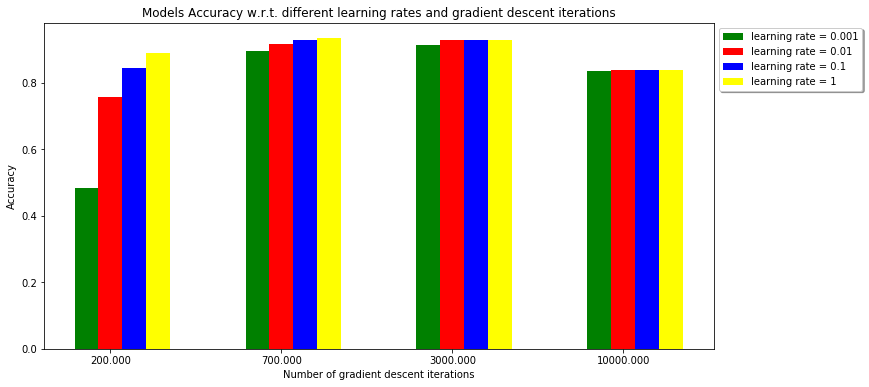

In [186]:
N = len(trainGrid['num_iters'].unique())
ind = np.arange(N)
width = 0.14

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
x_001 = tuple(list(trainGrid[trainGrid['step_size'] == 0.001].accuracy_mean))
rects1 = ax.bar(ind,x_001,width,color = 'g')

x_01 = trainGrid[trainGrid['step_size'] == 0.01].accuracy_mean
rects2 = ax.bar(ind+width,x_01,width,color= 'r')

x_1 = trainGrid[trainGrid['step_size'] == 0.1].accuracy_mean
rects3 = ax.bar(ind+(2*width),x_1,width,color = 'b')

x1 = trainGrid[trainGrid['step_size'] == 1].accuracy_mean
rects4 = ax.bar(ind+(3*width),x1,width,color = 'yellow')

ax.set_xlabel('Number of gradient descent iterations')
ax.set_ylabel('Accuracy')
ax.set_title('Models Accuracy w.r.t. different learning rates and gradient descent iterations')
ax.set_xticks(ind+width)
#ax.annotate()
ax.set_xticklabels(tuple(["{0:0.3f}".format(x) for x in (trainGrid.num_iters.unique())]))
ax.legend((rects1[0], rects2[0], rects3[0],rects4[0],), ('learning rate = 0.001', 'learning rate = 0.01','learning rate = 0.1','learning rate = 1'),
          loc='upper left', bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True)
#ax.annotate()

plt.show()

In [187]:
import itertools
import pandas as pd

def expandgrid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [188]:
# Question 6 : What is the sensitivity of the model’s performance to different regularization parameter values. Find the best 
#              regularization parameter using an exhaustive search procedure. Describe your choice via suitable plots. What is 
#              the performance difference between using regularization and no regularization?

#Using the best fit found in the last part, we'll try to find the best regularization parameter:

trainGrid_reg = expandgrid({ 'reg': [1e-1,1e-2,1e-3,1e-4,0],
                              'num_iters':[3000],
                              'step_size': [1e-1],
                              'accuracy_mean': [0.0], #create a column to store accuracies in
                              
                        })
trainGrid_reg

,reg,num_iters,step_size,accuracy_mean
0,0.1000,3000,0.1,0.0
1,0.0100,3000,0.1,0.0
2,0.0010,3000,0.1,0.0
3,0.0001,3000,0.1,0.0
4,0.0000,3000,0.1,0.0


In [189]:
for idx,item in trainGrid_reg.iterrows():
    print(item)
    kfold = KFold(5)
    validation_accuracy=[]
    iterations=int(item['num_iters'])
    stepsize=item['step_size'] 
    
    reg=int(item['reg'])
    for k,(train,test) in enumerate(kfold.split(X,y)):
        W = W_cv
        b = b_cv
        W2=W2_cv
        b2=b2_cv
        W3=W3_cv
        b3=b3_cv
        num_examples=X[train].shape[0]
        W,W2,W3,b,b2,b3,accuracy=grad_descent_maxout(X[train], X[test], y[train], y[test],W,W2,W3,b,b2,b3,reg,step_size,num_examples,iterations)
        validation_accuracy.append(accuracy)
        print('Validation Accuracy for fold %d: %.2f' % (k, accuracy))
        print('done processing for k: %d' % k)
    
    #Avg_validation_accuracy.append(np.mean(validation_accuracy))
    trainGrid_reg.loc[idx,'accuracy_mean']=np.mean(validation_accuracy)
    print("Accuracy: %0.2f " % (trainGrid_reg.loc[idx,'accuracy_mean']))
    print('**************')

reg                 0.1
num_iters        3000.0
step_size           0.1
accuracy_mean       0.0
Name: 0, dtype: float64
Validation Accuracy for fold 0: 0.83
done processing for k: 0
Validation Accuracy for fold 1: 0.90
done processing for k: 1
Validation Accuracy for fold 2: 1.00
done processing for k: 2
Validation Accuracy for fold 3: 0.87
done processing for k: 3
Validation Accuracy for fold 4: 0.93
done processing for k: 4
Accuracy: 0.91 
**************
reg                 0.01
num_iters        3000.00
step_size           0.10
accuracy_mean       0.00
Name: 1, dtype: float64
Validation Accuracy for fold 0: 0.88
done processing for k: 0
Validation Accuracy for fold 1: 0.92
done processing for k: 1
Validation Accuracy for fold 2: 1.00
done processing for k: 2
Validation Accuracy for fold 3: 0.90
done processing for k: 3
Validation Accuracy for fold 4: 1.00
done processing for k: 4
Accuracy: 0.94 
**************
reg                 0.001
num_iters        3000.000
step_size           0.

In [190]:
trainGrid_reg

,reg,num_iters,step_size,accuracy_mean
0,0.1000,3000,0.1,0.906667
1,0.0100,3000,0.1,0.940000
2,0.0010,3000,0.1,0.943333
3,0.0001,3000,0.1,0.946667
4,0.0000,3000,0.1,0.946667


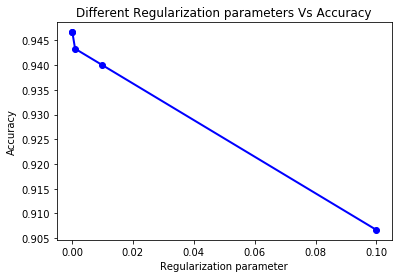

In [194]:
plt.plot(trainGrid_reg['reg'],trainGrid_reg['accuracy_mean'],'bo-',  linewidth=2)
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')
plt.title('Different Regularization parameters Vs Accuracy')
plt.show()

In [191]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50)

In [195]:
# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 100 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))

W3 = 0.05 * np.random.randn(h,K)
b3 = np.zeros((1,K))

W2 = 0.05 * np.random.randn(D,h)
b2 = np.zeros((1,h))

W_cv=W
b_cv=b
W2_cv=W2
b2_cv=b2
W3_cv=W3
b3_cv=b3

# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=3000

In [196]:
W,W2,W3,b,b2,b3,Test_Accuracy = grad_descent_maxout(xtrain, xtest, ytrain, ytest,W,W2,W3,b,b2,b3,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)

Test Accuracy: 0.88


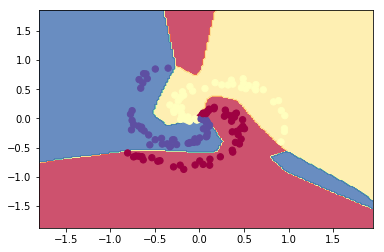

In [197]:
h = 0.020
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(np.dot(np.c_[xx.ravel(), yy.ravel()], W2) + b2, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W3) + b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

In [198]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.40)
# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 100 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))
print(W.shape)

W3 = 0.05 * np.random.randn(h,K)
b3 = np.zeros((1,K))

W2 = 0.05 * np.random.randn(D,h)
b2 = np.zeros((1,h))

# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=3000

W,W2,W3,b,b2,b3,Test_Accuracy = grad_descent_maxout(xtrain, xtest, ytrain, ytest,W,W2,W3,b,b2,b3,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)

(2, 100)
Test Accuracy: 0.90


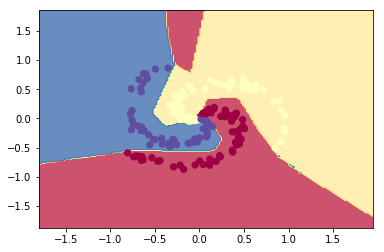

In [199]:
h = 0.020
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(np.dot(np.c_[xx.ravel(), yy.ravel()], W2) + b2, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W3) + b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

# Question 4

# number of hidden units much smaller h=5

In [200]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)
# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 5 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))

W2 = 0.05 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=5000

W,W2,b,b2,Test_Accuracy = grad_descent_relu(xtrain, xtest, ytrain, ytest,W,W2,b,b2,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)

Test Accuracy: 0.63


In [201]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)

# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 5 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))

W2 = 0.05 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=5000

W,W2,b,b2,Test_Accuracy = grad_descent_Leaky_relu(xtrain, xtest, ytrain, ytest,W,W2,b,b2,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)

Test Accuracy: 0.62


In [202]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)
# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 5 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))
print(W.shape)

W3 = 0.05 * np.random.randn(h,K)
b3 = np.zeros((1,K))

W2 = 0.05 * np.random.randn(D,h)
b2 = np.zeros((1,h))

# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=3000

W,W2,W3,b,b2,b3,Test_Accuracy = grad_descent_maxout(xtrain, xtest, ytrain, ytest,W,W2,W3,b,b2,b3,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)

(2, 5)
Test Accuracy: 0.80


# number of hidden units much smaller h=500

In [205]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)
# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 1000 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))
print(W.shape)

W3 = 0.05 * np.random.randn(h,K)
b3 = np.zeros((1,K))

W2 = 0.05 * np.random.randn(D,h)
b2 = np.zeros((1,h))

# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=3000

W,W2,W3,b,b2,b3,Test_Accuracy = grad_descent_maxout(xtrain, xtest, ytrain, ytest,W,W2,W3,b,b2,b3,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)

(2, 1000)
Test Accuracy: 0.97


In [206]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)

# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 1000 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))

W2 = 0.05 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=5000

W,W2,b,b2,Test_Accuracy = grad_descent_Leaky_relu(xtrain, xtest, ytrain, ytest,W,W2,b,b2,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)

Test Accuracy: 0.98


In [207]:
np.random.seed(0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)
# Feedforward neural net model
np.random.seed(0)
D = xtrain.shape[1] #Number of features
K = max(ytrain)+1 #Number of classes assuming class index starts from 0
# Start with an initialize parameters randomly
h = 1000 # size of hidden layer
W = 0.05 * np.random.randn(D,h)
b = np.zeros((1,h))

W2 = 0.05 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# Initial values from hyperparameter
reg = 1e-4 # regularization strength
#For simplicity we will take the batch size to be the same as number of examples
num_examples = xtrain.shape[0]
#Initial value for the Gradient Descent Parameter
step_size = 1e-1 #Also called learning rate
iterations=5000

W,W2,b,b2,Test_Accuracy = grad_descent_relu(xtrain, xtest, ytrain, ytest,W,W2,b,b2,reg,step_size,num_examples,iterations) 
print('Test Accuracy: %.2f' % Test_Accuracy)

Test Accuracy: 0.98
